In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; 
# warnings.filterwarnings('ignore')

import os
import sys
sys.path.append(os.path.abspath('../'))
import abupy
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

only use pandas calc nd, please install talib!
enable example env will only read RomDataBu/df_kl.h5


## 第8章 量化系统-开发

## 8.1 abu量化系统择时
### 8.1.1 买入因子的实现

In [3]:
from abupy import AbuFactorBuyBreak
from abupy import AbuBenchmark
# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]
benchmark = AbuBenchmark()

In [4]:
from abupy import AbuPickTimeWorker 
from abupy import AbuCapital
from abupy import AbuKLManager

capital = AbuCapital(1000000, benchmark)
kl_pd_manager = AbuKLManager(benchmark, capital)
# 获取TSLA的交易数据
kl_pd = kl_pd_manager.get_pick_time_kl_pd('usTSLA')
abu_worker = AbuPickTimeWorker(capital, kl_pd, buy_factors, None)
%time abu_worker.fit()

CPU times: user 121 ms, sys: 484 µs, total: 122 ms
Wall time: 122 ms


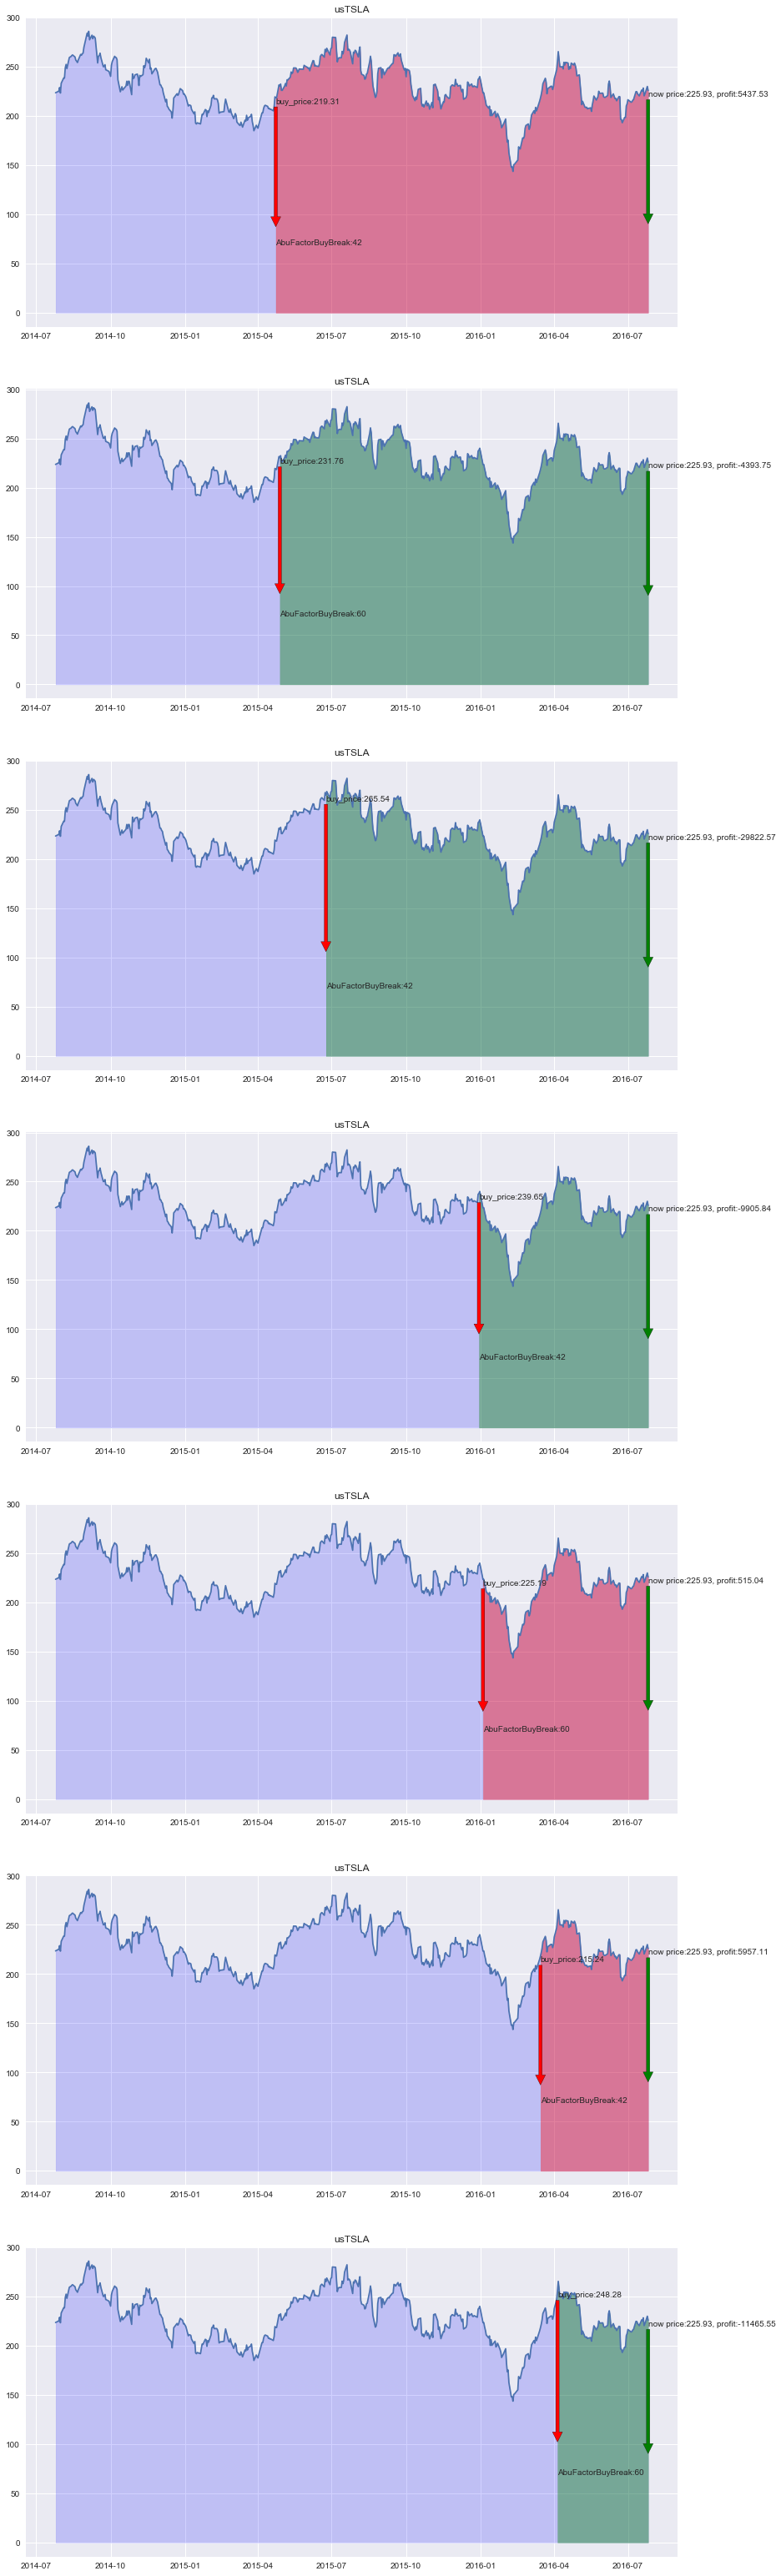

In [5]:
from abupy import ABuTradeProxy
orders_pd, action_pd, _ = ABuTradeProxy.trade_summary(abu_worker.orders, kl_pd, draw=True)

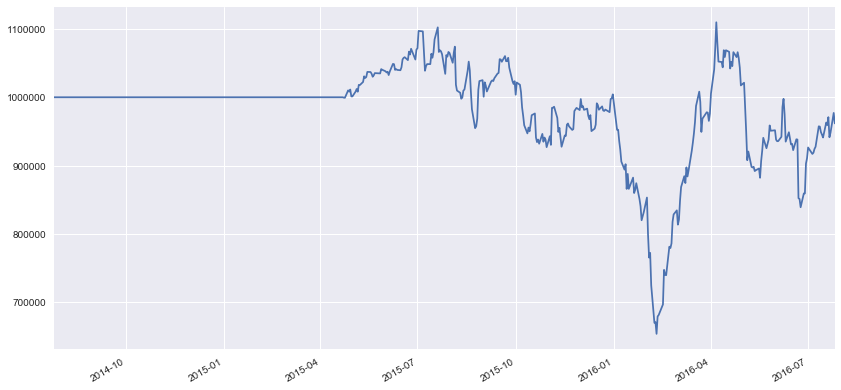

In [6]:
from abupy import ABuTradeExecute
ABuTradeExecute.apply_action_to_capital(capital, action_pd, kl_pd_manager)
capital.capital_pd.capital_blance.plot()

### 8.1.2 卖出因子的实现

In [6]:
from abupy import AbuFactorSellBreak
# 使用120天向下突破为卖出信号
sell_factor1 = {'xd': 120, 'class': AbuFactorSellBreak}

pid:55211 pick times complete:100.0%


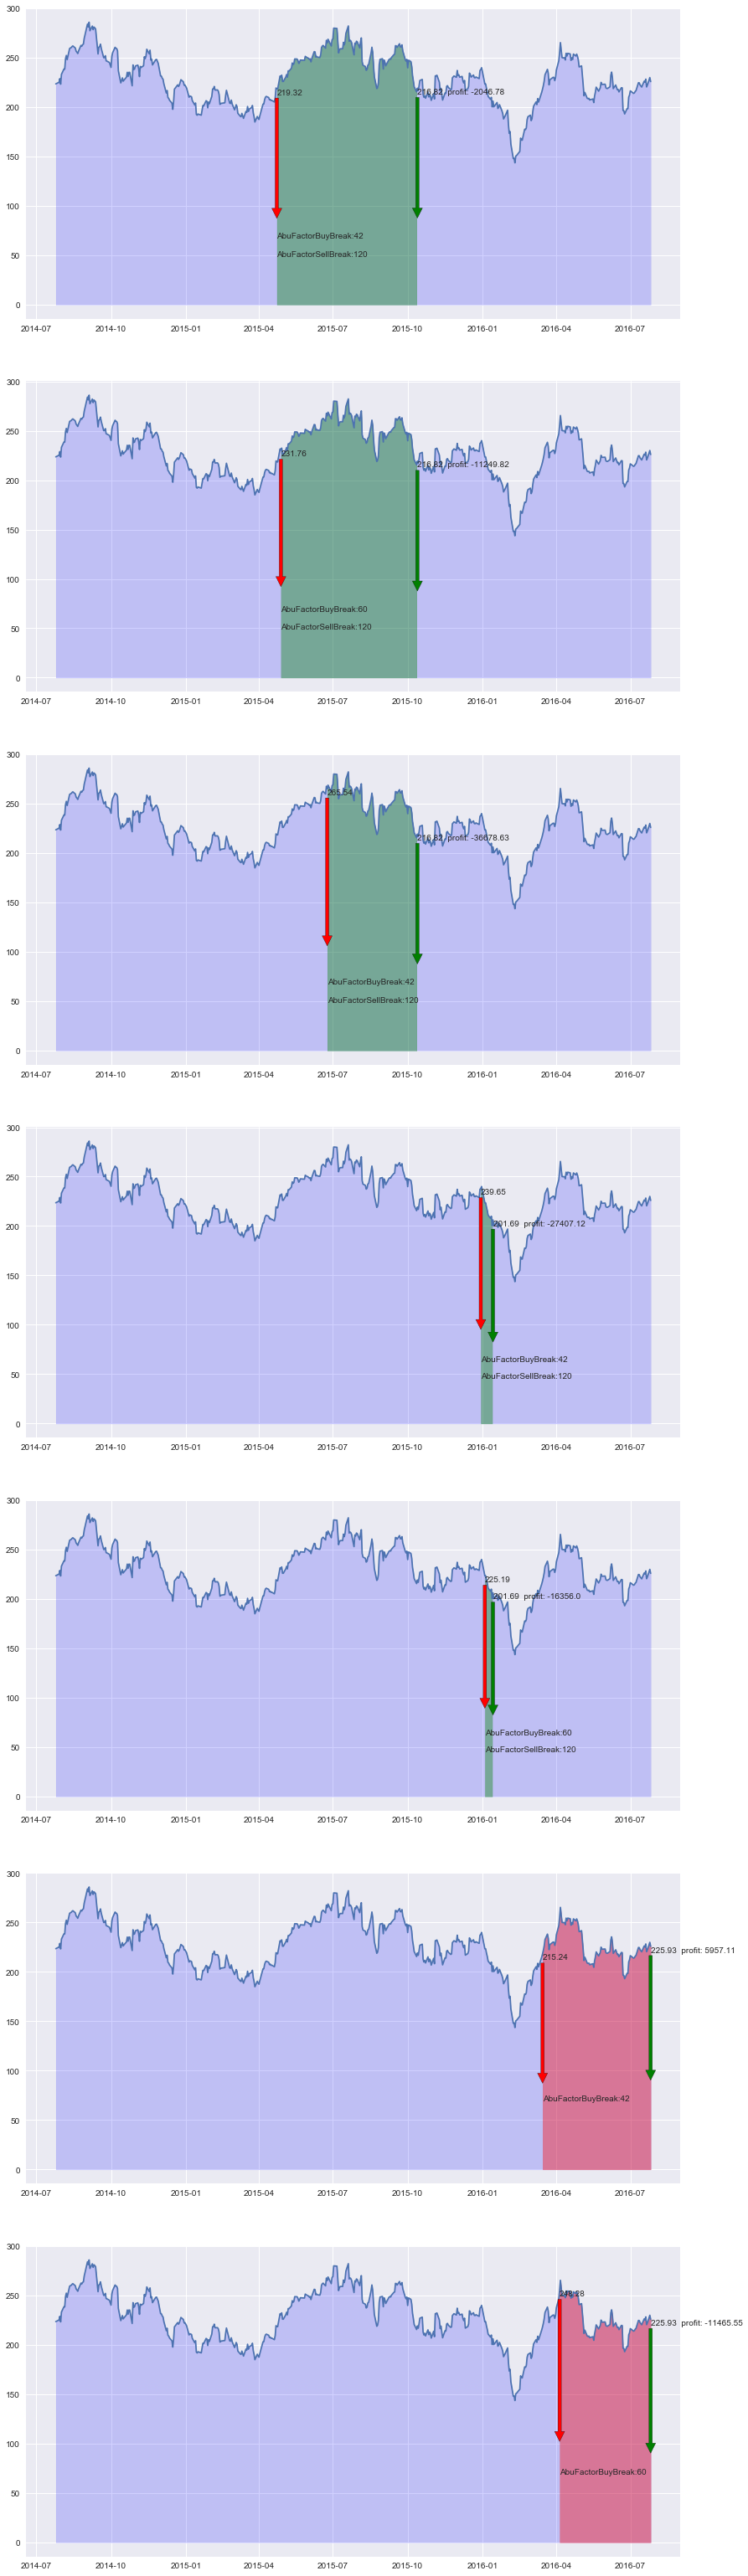

In [7]:
from abupy import ABuPickTimeExecute
# 只使用120天向下突破为卖出因子
sell_factors = [sell_factor1]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usTSLA'], benchmark, buy_factors, sell_factors, capital, show=True)

pid:55211 pick times complete:100.0%


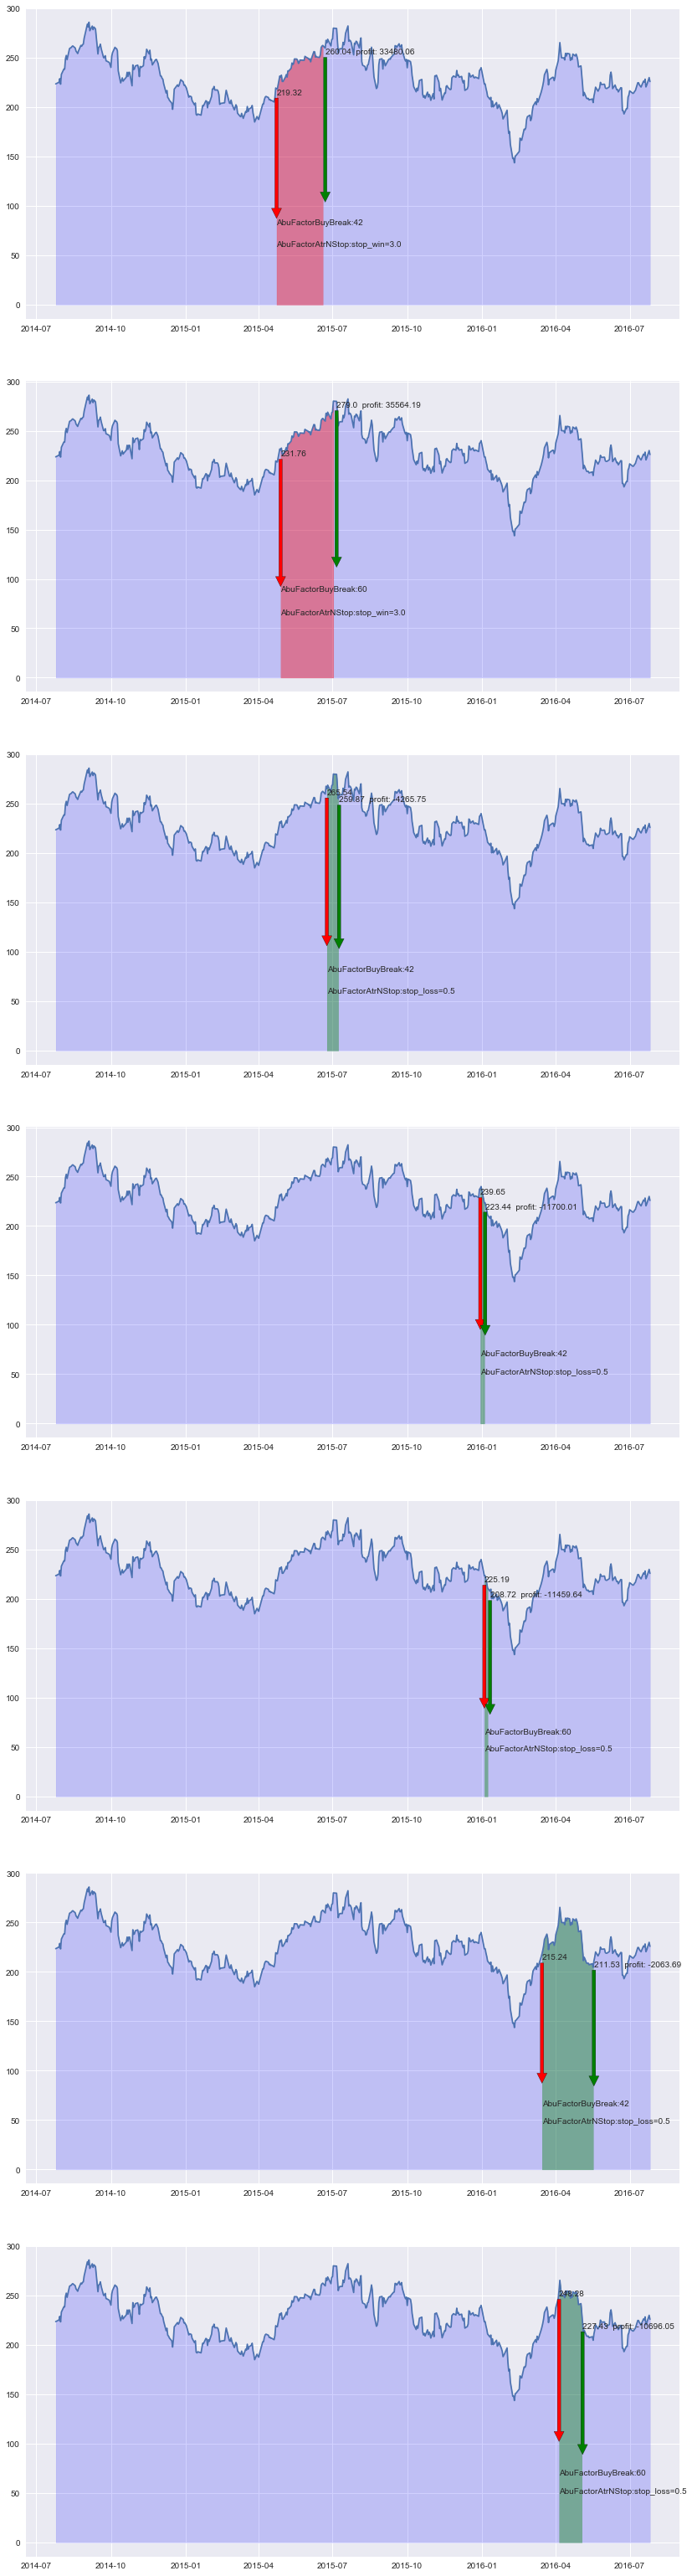

In [8]:
from abupy import AbuFactorAtrNStop
# 趋势跟踪策略止盈要大于止损设置值，这里0.5，3.0
sell_factor2 = {'stop_loss_n':0.5, 'stop_win_n':3.0, 'class': AbuFactorAtrNStop}
# 两个卖出因子策略并行同时生效
sell_factors = [sell_factor1, sell_factor2]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usTSLA'], benchmark, buy_factors, sell_factors, capital, show=True)

pid:55211 pick times complete:100.0%


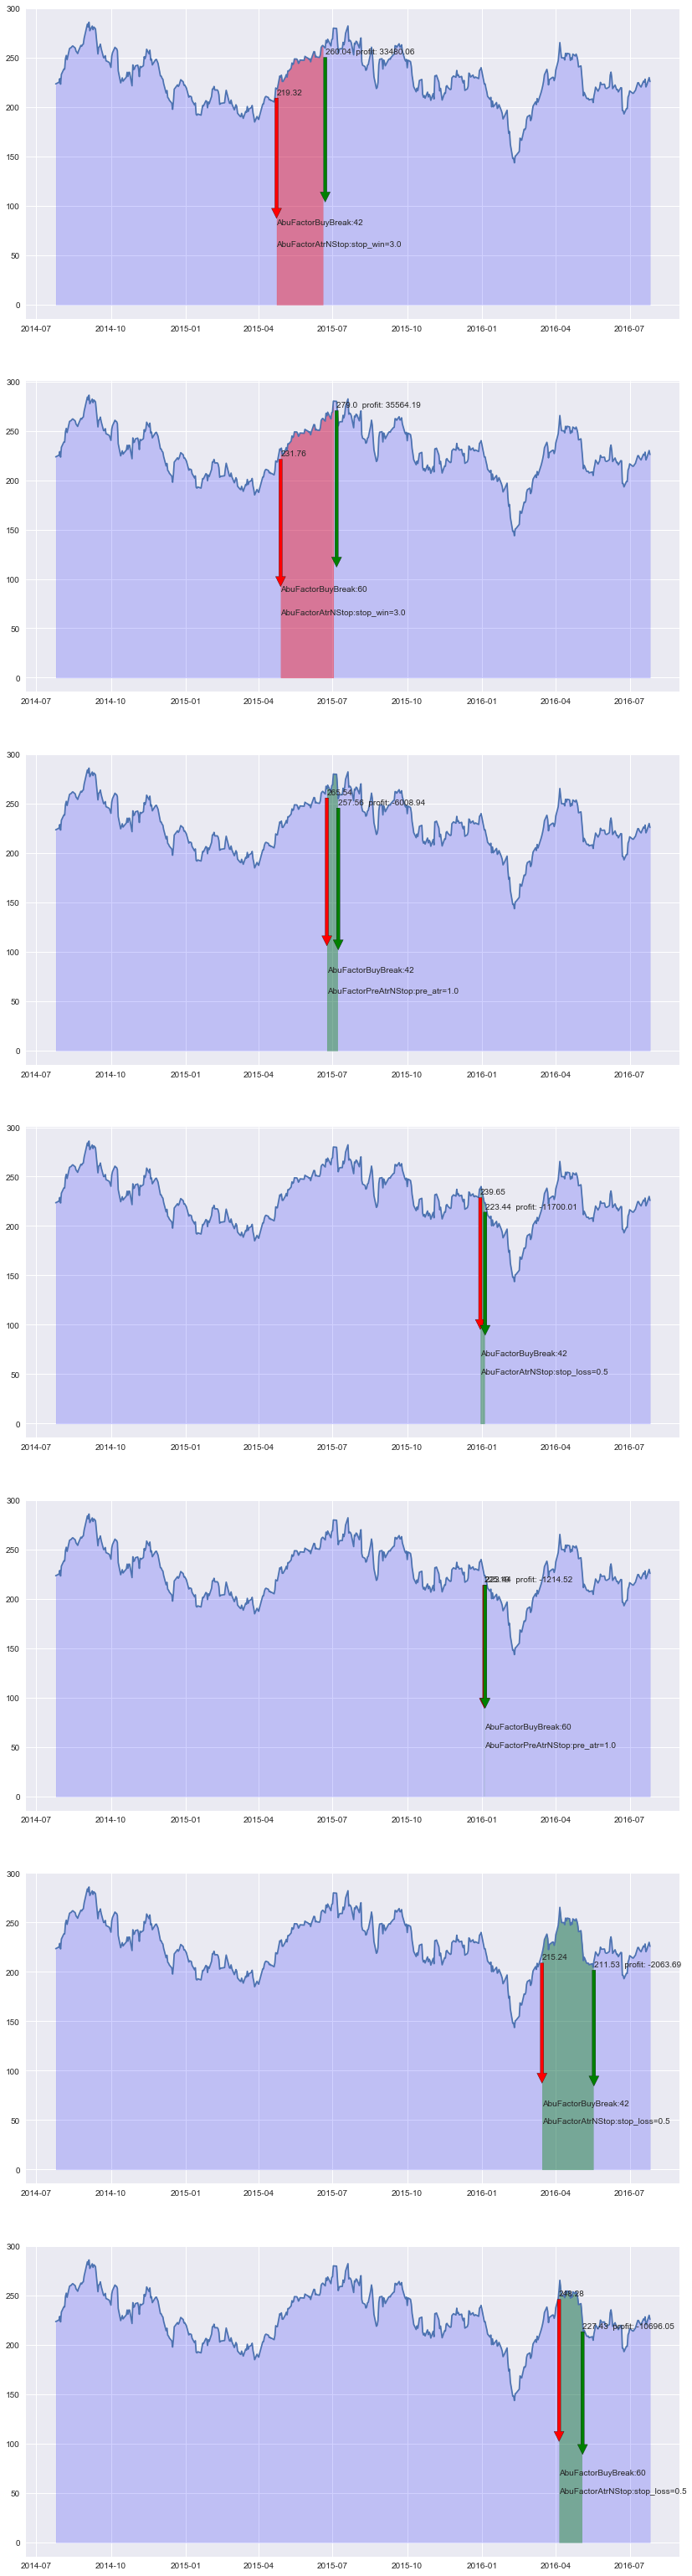

In [10]:
from abupy import AbuFactorPreAtrNStop
# 暴跌止损卖出因子形成dict
sell_factor3 =  {'class': AbuFactorPreAtrNStop, 'pre_atr_n':1.0}
# 三个卖出因子同时生效，组成sell_factors
sell_factors = [sell_factor1, sell_factor2, sell_factor3]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usTSLA'], benchmark, buy_factors, sell_factors, capital, show=True)

pid:55211 pick times complete:100.0%


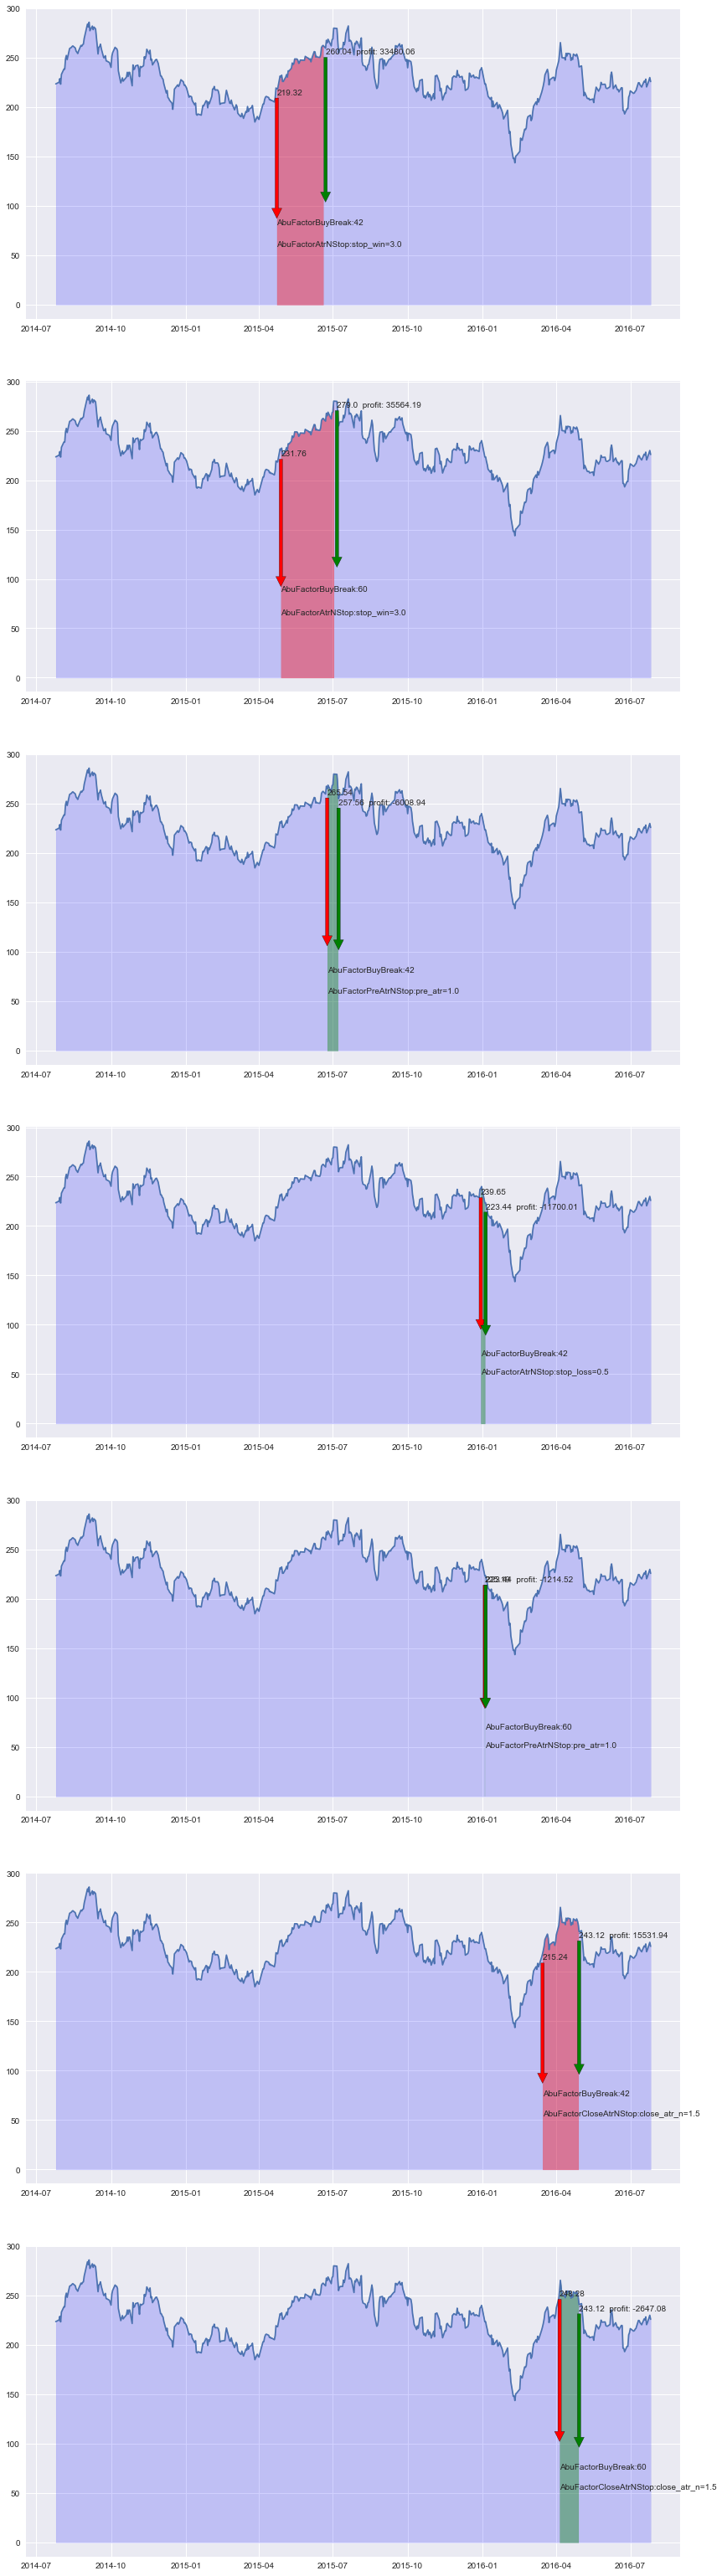

In [11]:
from abupy import AbuFactorCloseAtrNStop
# 保护止盈卖出因子组成dict
sell_factor4 = {'class': AbuFactorCloseAtrNStop, 'close_atr_n':1.5}
# 四个卖出因子同时并行生效
sell_factors = [sell_factor1, sell_factor2, sell_factor3, sell_factor4]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usTSLA'], benchmark, buy_factors, sell_factors, capital, show=True)

### 8.1.3 滑点买入卖出价格确定及策略实现

In [13]:
from abupy import AbuSlippageBuyBase

# 修改g_open_down_rate的值为0.02
g_open_down_rate = 0.02

class AbuSlippageBuyMean2(AbuSlippageBuyBase):
    def fit_price(self):
        if (self.kl_pd_buy.open / self.kl_pd_buy.pre_close) < (
            1 - g_open_down_rate):
            # 开盘下跌K_OPEN_DOWN_RATE以上，单子失效
            print(self.factor_name + 'open down threshold')
            return np.inf
        # 买入价格为当天均价
        self.buy_price = np.mean(
            [self.kl_pd_buy['high'], self.kl_pd_buy['low']])
        return self.buy_price

pid:21813 pick times complete:100.0%
AbuFactorBuyBreak:60open down threshold
AbuFactorBuyBreak:60open down threshold


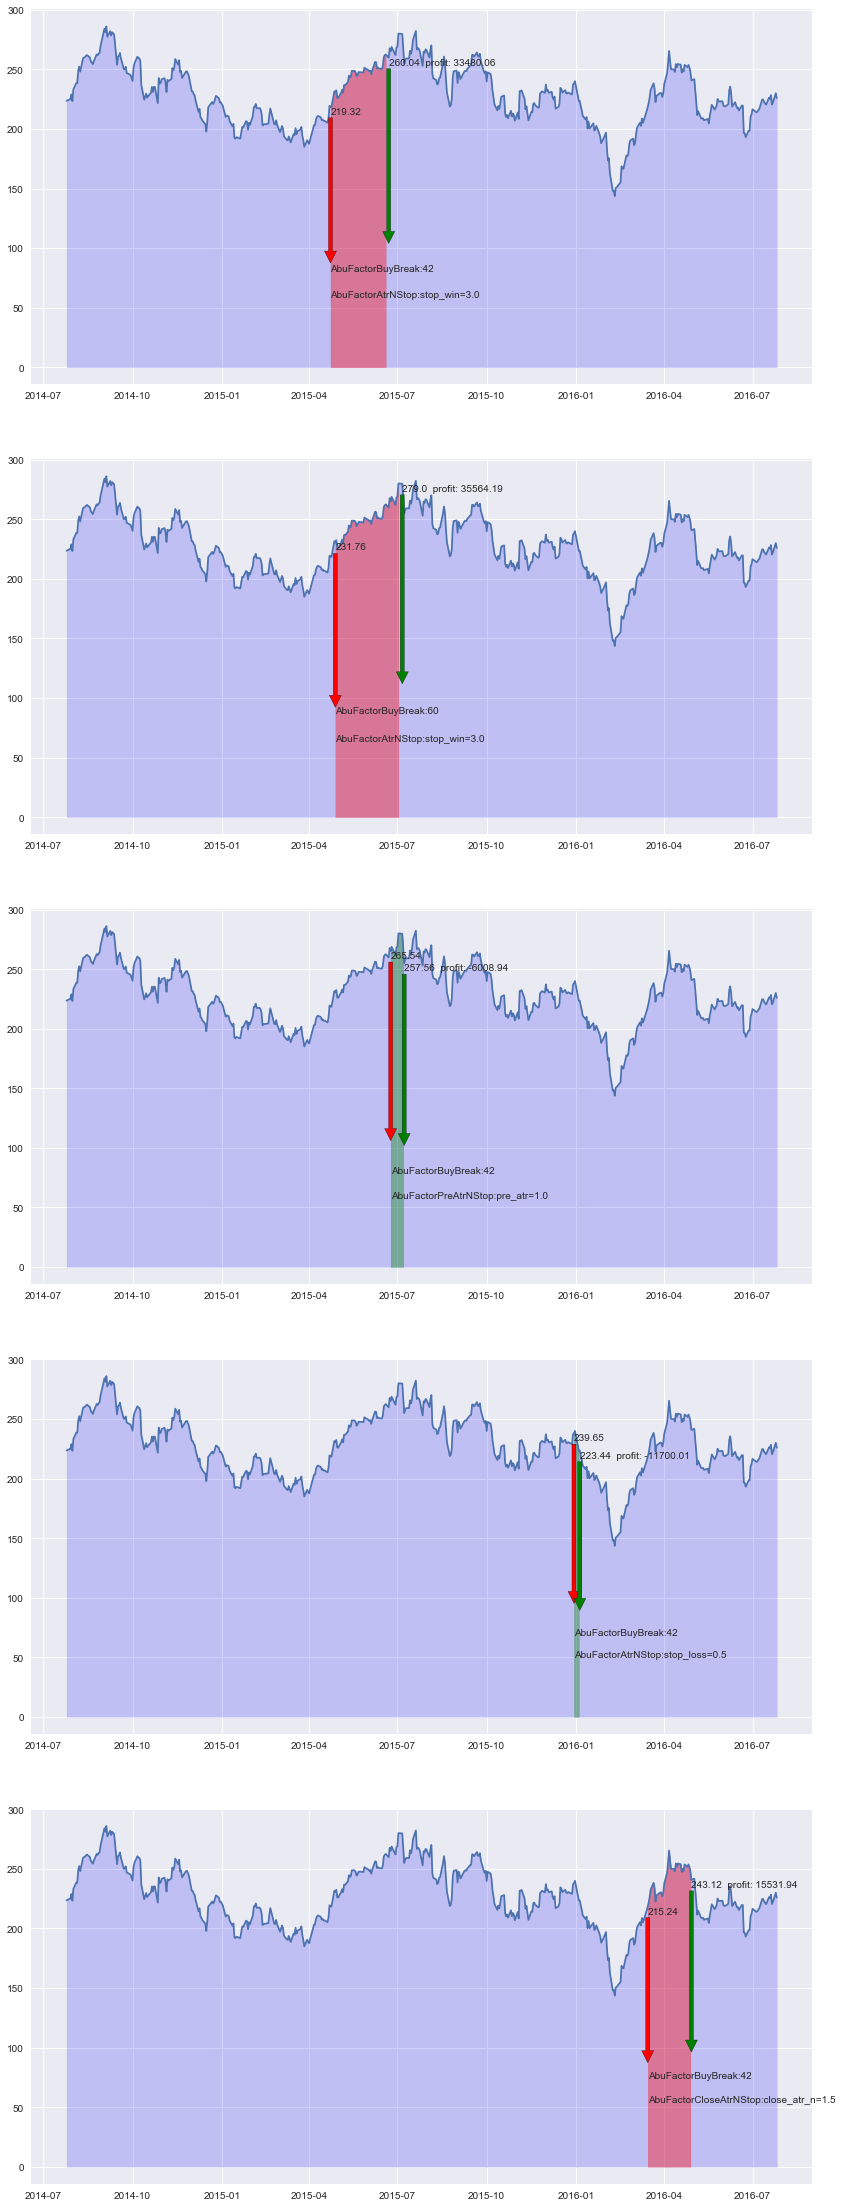

In [14]:
# 只针对60使用AbuSlippageBuyMean2
buy_factors2 = [{'slippage': AbuSlippageBuyMean2, 'xd': 60,
                 'class': AbuFactorBuyBreak},
                {'xd': 42, 'class': AbuFactorBuyBreak}]

sell_factors = [sell_factor1, sell_factor2, sell_factor3,
                sell_factor4]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = \
    ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                    benchmark,
                                                    buy_factors2,
                                                    sell_factors,
                                                    capital,
                                                    show=True)

### 8.1.4 对多支股票进行择时

In [15]:
# 我们假定choice_symbols是我们选股模块的结果，
choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usWUBA', 'usVIPS']
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, all_fit_symbols_cnt = ABuPickTimeExecute.do_symbols_with_same_factors(choice_symbols, benchmark, buy_factors, sell_factors, capital, show=False)

pid:21813 pick times complete:100.0%


In [16]:
orders_pd[:10].filter(['symbol', 'buy_price', 'buy_cnt', 'buy_factor', 'buy_pos', 
                       'sell_date', 'sell_type_extra', 'sell_type', 'profit'])

,symbol,buy_price,buy_cnt,buy_factor,buy_pos,sell_date,sell_type_extra,sell_type,profit
2014-10-24,usAAPL,105.010,1904,AbuFactorBuyBreak:60,AbuAtrPosition,20141202,AbuFactorPreAtrNStop:pre_atr=1.0,win,17592.96
2014-10-24,usAAPL,105.010,1904,AbuFactorBuyBreak:42,AbuAtrPosition,20141202,AbuFactorPreAtrNStop:pre_atr=1.0,win,17592.96
2014-10-29,usBIDU,223.680,781,AbuFactorBuyBreak:42,AbuAtrPosition,20141202,AbuFactorPreAtrNStop:pre_atr=1.0,win,9473.53
2014-10-29,usNOAH,16.010,9217,AbuFactorBuyBreak:42,AbuAtrPosition,20141208,AbuFactorAtrNStop:stop_win=3.0,win,74104.68
2014-10-29,usVIPS,21.430,6095,AbuFactorBuyBreak:42,AbuAtrPosition,20141105,AbuFactorPreAtrNStop:pre_atr=1.0,win,12433.80
2014-10-29,usBIDU,223.680,781,AbuFactorBuyBreak:60,AbuAtrPosition,20141202,AbuFactorPreAtrNStop:pre_atr=1.0,win,9473.53
2014-11-03,usVIPS,23.364,5900,AbuFactorBuyBreak:60,AbuAtrPosition,20141105,AbuFactorPreAtrNStop:pre_atr=1.0,win,625.40
2014-11-11,usNOAH,16.990,9491,AbuFactorBuyBreak:60,AbuAtrPosition,20141211,AbuFactorCloseAtrNStop:close_atr_n=1.5,win,29944.11
2014-11-12,usWUBA,43.250,2945,AbuFactorBuyBreak:42,AbuAtrPosition,20141209,AbuFactorPreAtrNStop:pre_atr=1.0,loss,-1789.09
2014-11-26,usWUBA,47.100,3262,AbuFactorBuyBreak:60,AbuAtrPosition,20141209,AbuFactorAtrNStop:stop_loss=0.5,loss,-14540.37


In [17]:
action_pd[:10]

,Date,Price,Cnt,symbol,action,deal
0,20141024,105.010,1904,usAAPL,buy,True
1,20141024,105.010,1904,usAAPL,buy,True
2,20141029,16.010,9217,usNOAH,buy,True
3,20141029,223.680,781,usBIDU,buy,True
4,20141029,223.680,781,usBIDU,buy,True
5,20141029,21.430,6095,usVIPS,buy,False
6,20141103,23.364,5900,usVIPS,buy,False
7,20141105,23.470,6095,usVIPS,sell,False
8,20141105,23.470,5900,usVIPS,sell,False
9,20141111,16.990,9491,usNOAH,buy,False


买入后卖出的交易数量:67
胜率:41.7910%
平均获利期望:12.0118%
平均亏损期望:-4.9109%
盈亏比:1.9336
策略收益: 27.1849%
基准收益: 15.0841%
策略年化收益: 13.5925%
基准年化收益: 7.5420%
策略买入成交比例:84.2857%
策略资金利用率比例:21.4491%
策略共执行504个交易日


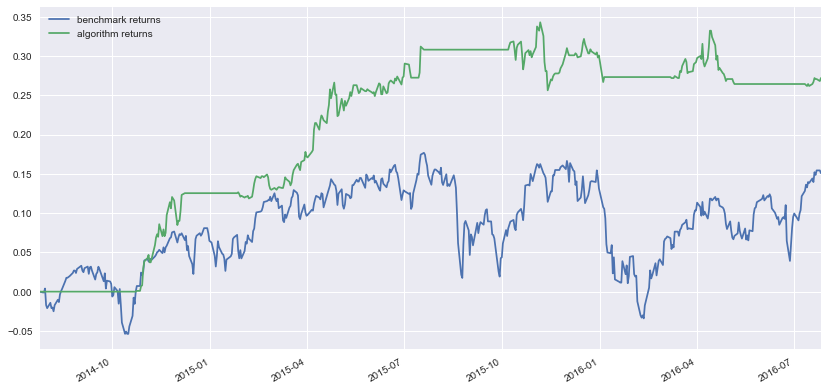

In [18]:
from abupy import AbuMetricsBase 
metrics = AbuMetricsBase(orders_pd, action_pd, capital, benchmark)
metrics.fit_metrics()
metrics.plot_returns_cmp(only_show_returns=True)

## 8.1.5 自定义仓位管理策略的实现

In [19]:
metrics.gains_mean, -metrics.losses_mean

(0.12011772917325268, 0.049108880754061404)

In [20]:
from abupy import AbuKellyPosition
# 42d使用AbuKellyPosition，60d仍然使用默认仓位管理类
buy_factors2 = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'position':AbuKellyPosition, 'win_rate': metrics.win_rate,
                'gains_mean': metrics.gains_mean, 'losses_mean': -metrics.losses_mean,
                'class': AbuFactorBuyBreak}]

capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, all_fit_symbols_cnt = ABuPickTimeExecute.do_symbols_with_same_factors(choice_symbols, benchmark, buy_factors2, sell_factors, capital, show=False)

pid:21813 pick times complete:100.0%


In [21]:
orders_pd[:10].filter(['symbol', 'buy_cnt', 'buy_factor', 'buy_pos'])

,symbol,buy_cnt,buy_factor,buy_pos
2014-10-24,usAAPL,1904,AbuFactorBuyBreak:60,AbuAtrPosition
2014-10-24,usAAPL,1713,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usBIDU,804,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usNOAH,11238,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usVIPS,8396,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usBIDU,781,AbuFactorBuyBreak:60,AbuAtrPosition
2014-11-03,usVIPS,5900,AbuFactorBuyBreak:60,AbuAtrPosition
2014-11-11,usNOAH,9491,AbuFactorBuyBreak:60,AbuAtrPosition
2014-11-12,usWUBA,4160,AbuFactorBuyBreak:42,AbuKellyPosition
2014-11-26,usWUBA,3262,AbuFactorBuyBreak:60,AbuAtrPosition


## 8.1.6 多支股票使用不同的因子进行择时

In [22]:
# 选定noah和sfun
target_symbols = ['usSFUN', 'usNOAH']
# 针对sfun只使用42d向上突破作为买入因子
buy_factors_sfun = [{'xd': 42, 'class': AbuFactorBuyBreak}]
# 针对sfun只使用60d向下突破作为卖出因子
sell_factors_sfun = [{'xd': 60, 'class': AbuFactorSellBreak}]

# 针对noah只使用21d向上突破作为买入因子
buy_factors_noah = [{'xd': 21, 'class': AbuFactorBuyBreak}]
# 针对noah只使用42d向下突破作为卖出因子
sell_factors_noah = [{'xd': 42, 'class': AbuFactorSellBreak}]

factor_dict = dict()
# 构建SFUN独立的buy_factors，sell_factors的dict
factor_dict['usSFUN'] = {'buy_factors':buy_factors_sfun, 'sell_factors':sell_factors_sfun}
# 构建NOAH独立的buy_factors，sell_factors的dict
factor_dict['usNOAH'] = {'buy_factors':buy_factors_noah, 'sell_factors':sell_factors_noah}
# 初始化资金
capital = AbuCapital(1000000, benchmark)
# 使用do_symbols_with_diff_factors执行
orders_pd, action_pd, all_fit_symbols = ABuPickTimeExecute.do_symbols_with_diff_factors(
                                        target_symbols, benchmark, factor_dict, capital)

pid:21813 pick times complete:100.0%


In [23]:
pd.crosstab(orders_pd.buy_factor, orders_pd.symbol)

symbol,usNOAH,usSFUN
buy_factor,,
AbuFactorBuyBreak:21,9,0
AbuFactorBuyBreak:42,0,4


## 8.1.7 使用并行来提升择时运行效率

In [7]:
# 要关闭沙盒数据环境，因为沙盒里就那几个股票的历史数据, 下面要随机做300个股票
abupy.env.disable_example_env_ipython()

# 关闭沙盒后，首先基准要从非沙盒环境换取，否则数据对不齐，无法正常运行
benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)
kl_pd_manager = AbuKLManager(benchmark, capital)

disable example env


In [25]:
from abupy import ABuMarket
# 当传入choice_symbols为None时代表对整个市场的所有股票进行回测
choice_symbols = None
# 顺序获取市场后300支股票
choice_symbols = ABuMarket.all_symbol()[-300:]
# 随机获取300支股票
choice_symbols = ABuMarket.choice_symbols(300)

In [26]:
from abupy import AbuPickTimeMaster
# 将atr仓位控制的仓位基数设置为1%，默认为10%，因为回测的股票数量提高了，所以降低g_pos_base
abupy.beta.atr.g_atr_pos_base = 0.01
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = AbuPickTimeMaster.do_symbols_with_same_factors_process(
                          choice_symbols, benchmark, buy_factors, sell_factors, 
                          capital, n_process_kl=32, n_process_pick_time=8)

买入后卖出的交易数量:1476
胜率:34.6883%
平均获利期望:9.0341%
平均亏损期望:-4.7221%
盈亏比:1.0629
策略收益: 0.6508%
基准收益: 22.6829%
策略年化收益: 0.3267%
基准年化收益: 11.3866%
策略买入成交比例:82.0984%
策略资金利用率比例:55.7591%
策略共执行502个交易日


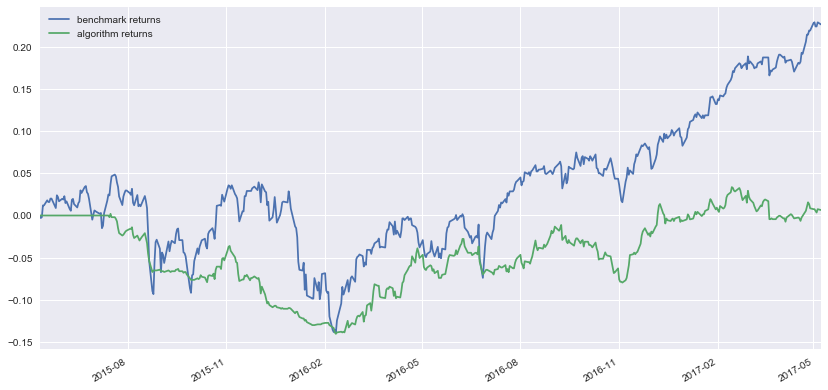

In [27]:
metrics = AbuMetricsBase(orders_pd, action_pd, capital, benchmark)
metrics.fit_metrics()
metrics.plot_returns_cmp(only_show_returns=True)

## 8.2 abu量化系统选股

### 8.2.1 选股因子的实现

In [8]:
# 继续使用沙盒数据环境
abupy.env.enable_example_env_ipython()

# 开启沙盒后，基准也要从沙盒环境取，否则数据对不齐，无法正常运行
benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)
kl_pd_manager = AbuKLManager(benchmark, capital)

enable example env will only read RomDataBu/df_kl.h5


In [10]:
from abupy import AbuPickRegressAngMinMax
from abupy import AbuPickStockWorker
# 选股条件threshold_ang_min=0.0, 即要求股票走势为向上上升趋势
stock_pickers = [{'class': AbuPickRegressAngMinMax, 
                'threshold_ang_min':0.0, 'reversed':False}]

# 从这几个股票里进行选股，只是为了演示方便，一般的选股都会是数量比较多的情况比如全市场股票
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usTSLA', 'usWUBA', 'usVIPS']

capital = AbuCapital(1000000, benchmark)
kl_pd_manager = AbuKLManager(benchmark, capital)
stock_pick = AbuPickStockWorker(capital, benchmark, kl_pd_manager, choice_symbols=choice_symbols, stock_pickers=stock_pickers)
stock_pick.fit()
stock_pick.choice_symbols

pid:1425 pick stocks complete:100.0%
pid:1425 pick stocks complete:100%


['usSFUN', 'usBIDU', 'usTSLA', 'usWUBA', 'usVIPS']

# 注意所有选股结果等等与书中的结果不一致，因为要控制沙盒数据体积小于50mb， 所以沙盒数据有些symbol只有两年多一点，与原始环境不一致，直接达不到选股的min_xd，所以这里其实可以`abupy.env.disable_example_env_ipython()`关闭沙盒环境，直接上真实数据。

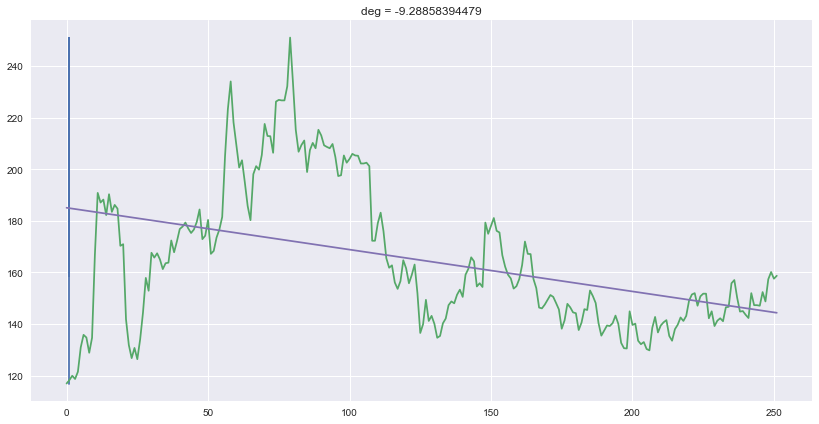

noah 选股周期内角度=-9.289


In [11]:
from abupy import ABuRegUtil
# 从kl_pd_manager缓存中获取选股走势数据，注意get_pick_stock_kl_pd为选股数据，get_pick_time_kl_pd为择时
kl_pd_noah = kl_pd_manager.get_pick_stock_kl_pd('usNOAH')
# 绘制并计算角度
deg = ABuRegUtil.calc_regress_deg(kl_pd_noah.close)
print('noah 选股周期内角度={}'.format(round(deg, 3)))

## ABuPickStockExecute

In [12]:
from abupy import ABuPickStockExecute
stock_pickers = [{'class': AbuPickRegressAngMinMax, 
                 'threshold_ang_min':0.0, 'threshold_ang_max':10.0, 'reversed':False}]

ABuPickStockExecute.do_pick_stock_work(choice_symbols, benchmark, capital, stock_pickers)

pid:1425 pick stocks complete:100.0%
pid:1425 pick stocks complete:100%


['usSFUN', 'usBIDU']

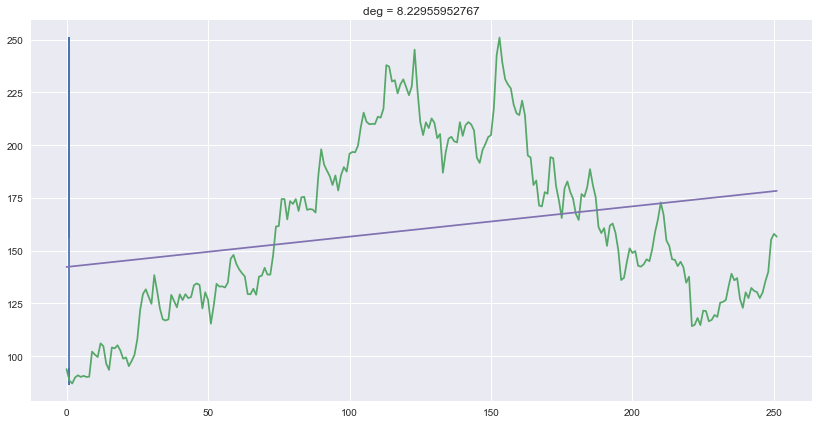

sfun 选股周期内角度=8.23


In [13]:
kl_pd_sfun = kl_pd_manager.get_pick_stock_kl_pd('usSFUN')
print('sfun 选股周期内角度={}'.format(round(ABuRegUtil.calc_regress_deg(kl_pd_sfun.close), 3)))

## reversed

In [33]:
# 和上面的代码唯一的区别就是reversed=True
stock_pickers = [{'class': AbuPickRegressAngMinMax, 
                 'threshold_ang_min':0.0, 'threshold_ang_max':10.0, 'reversed':True}]
ABuPickStockExecute.do_pick_stock_work(choice_symbols, benchmark, capital, stock_pickers)

['usNOAH', 'usTSLA', 'usVIPS']

### 8.2.2 多个选股因子并行执行

In [34]:
from abupy import AbuPickStockPriceMinMax

stock_pickers = [{'class': AbuPickRegressAngMinMax, 
                 'threshold_ang_min':0.0, 'reversed':False}, 
                 {'class': AbuPickStockPriceMinMax, 'threshold_price_min':50.0,
                 'reversed':False}]
ABuPickStockExecute.do_pick_stock_work(choice_symbols, benchmark, capital, stock_pickers)

['usBIDU', 'usTSLA']

### 8.2.3 使用并行来提升回测运行效率

In [15]:
# 继续关闭沙盒环境，因为下面要choice_symbols(300) 
abupy.env.disable_example_env_ipython()

# 关闭沙盒后，首先基准要从非沙盒环境换取，否则数据对不齐，无法正常运行
benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)
kl_pd_manager = AbuKLManager(benchmark, capital)

from abupy import ABuMarket, AbuPickStockMaster
# 首先随抽取300支股票
choice_symbols = ABuMarket.choice_symbols(300) 

disable example env


In [36]:
# 股价在15-50之间
stock_pickers = [{'class': AbuPickStockPriceMinMax, 'threshold_price_min':15.0,
                'threshold_price_max':50.0, 'reversed':False}]
%time cs = AbuPickStockMaster.do_pick_stock_with_process(capital, benchmark, stock_pickers, choice_symbols)

CPU times: user 24.5 s, sys: 1.03 s, total: 25.5 s
Wall time: 4min 29s


## 公共数据源使用hdf5，导致很多并非问题，这里如果n_thread > 1 cash。

In [ ]:
%time cs2 = AbuPickStockMaster.do_pick_stock_with_process_mix_thread(\
            capital, benchmark, stock_pickers, choice_symbols, n_process=8, n_thread=1)

In [7]:
print(len(cs))
print(len(cs2))
print(len(set(cs) & set(cs2)))

104
104
104
